In [27]:
import pandas as pd
df = pd.read_csv('paro.csv')
df = df.iloc[:-2] #eliminar las dos últimas filas
df

,Date,Unemployment_rate
0,1986-04-01,20.6
1,1986-05-01,20.5
2,1986-06-01,20.4
3,1986-07-01,20.4
4,1986-08-01,20.3
...,...,...
446,2023-06-01,11.9
447,2023-07-01,12.0
448,2023-08-01,11.9
449,2023-09-01,12.0


In [28]:
df['Date']

0      1986-04-01
1      1986-05-01
2      1986-06-01
3      1986-07-01
4      1986-08-01
          ...    
446    2023-06-01
447    2023-07-01
448    2023-08-01
449    2023-09-01
450    2023-10-01
Name: Date, Length: 451, dtype: object

In [29]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year,month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year,month=month,day = day)

datetime_object = str_to_datetime('1890-06-12')
datetime_object

datetime.datetime(1890, 6, 12, 0, 0)

In [30]:
"Por si no cargase la columna Date como fecha"
df['Date']=df['Date'].apply(str_to_datetime)
df['Date']

0     1986-04-01
1     1986-05-01
2     1986-06-01
3     1986-07-01
4     1986-08-01
         ...    
446   2023-06-01
447   2023-07-01
448   2023-08-01
449   2023-09-01
450   2023-10-01
Name: Date, Length: 451, dtype: datetime64[ns]

In [31]:
#Cambiamos el índice
df.index = df.pop('Date')
df


,Unemployment_rate
Date,
1986-04-01,20.6
1986-05-01,20.5
1986-06-01,20.4
1986-07-01,20.4
1986-08-01,20.3
...,...
2023-06-01,11.9
2023-07-01,12.0
2023-08-01,11.9


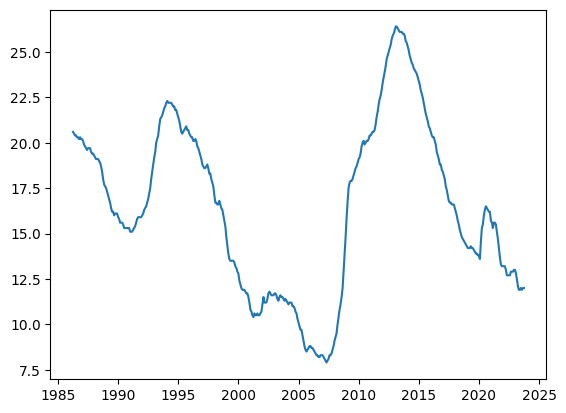

In [32]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Unemployment_rate'])


In [36]:
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Unemployment_rate'].shift(i)
    windowed_data['Target'] = data['Unemployment_rate']
    return windowed_data.dropna()

# Start day second time around: '2021-03-25'
windowed_df = window_data(df,n=3)
windowed_df

,Target-3,Target-2,Target-1,Target
Date,,,,
1986-07-01,20.6,20.5,20.4,20.4
1986-08-01,20.5,20.4,20.4,20.3
1986-09-01,20.4,20.4,20.3,20.3
1986-10-01,20.4,20.3,20.3,20.2
1986-11-01,20.3,20.3,20.2,20.3
...,...,...,...,...
2023-06-01,12.5,12.1,11.9,11.9
2023-07-01,12.1,11.9,11.9,12.0
2023-08-01,11.9,11.9,12.0,11.9


In [38]:
windowed_df = windowed_df.reset_index(drop=False)
windowed_df

,Date,Target-3,Target-2,Target-1,Target
0,1986-07-01,20.6,20.5,20.4,20.4
1,1986-08-01,20.5,20.4,20.4,20.3
2,1986-09-01,20.4,20.4,20.3,20.3
3,1986-10-01,20.4,20.3,20.3,20.2
4,1986-11-01,20.3,20.3,20.2,20.3
...,...,...,...,...,...
443,2023-06-01,12.5,12.1,11.9,11.9
444,2023-07-01,12.1,11.9,11.9,12.0
445,2023-08-01,11.9,11.9,12.0,11.9
446,2023-09-01,11.9,12.0,11.9,12.0


In [39]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((448,), (448, 3, 1), (448,))

Ahora vamos a dividir los datos entre train, validation, y test.

La intencion es que train entrene el modelo, el validation le ayude y el test evalue la actuación del modelo

)

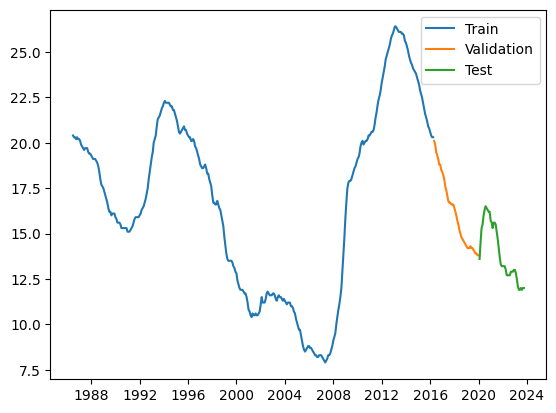

In [41]:
q_80 = int(len(dates) * .8)  #Percentil 80
q_90 = int(len(dates) * .9)  #Percentil 90

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] #El 80% de los datos

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] #10% de los datos siguientes
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] #10% último

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

CREACIÓN DEL MODELO


In [42]:
from tensorflow.keras.models import Sequential #crear el modelo secuencial
from tensorflow.keras.optimizers import Adam #optimizador Adam, es muy utilizado
from tensorflow.keras import layers #capas del modelo secuencial

model = Sequential([layers.Input((3, 1)), #3 porque es el Target-3,-2 y -1 y solo necesitamos 1 porque es univariable
                    layers.LSTM(64), #nº de neuronas para la capa LSTM. Cuanto más grande, mas complicado es el modelo. 64 es un muy buen número.
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)]) #output del modelo

#Procedemos a compilar el modelo
model.compile(loss='mse', #funcion que queremos minimizar es el error medio cuadrático
              optimizer=Adam(learning_rate=0.001), #adaptive moment estimation, es un algoritmo de optimización
              metrics=['mean_absolute_error']) #tambien interesa obtener el error medio absoluto

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100) #lo realizara 100 veces hasta obtener la mejor version

Epoch 1/100
12/12 [==============================] - 2s 43ms/step - loss: 294.3828 - mean_absolute_error: 16.3899 - val_loss: 234.1604 - val_mean_absolute_error: 15.1798
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 260.1119 - mean_absolute_error: 15.2883 - val_loss: 185.0812 - val_mean_absolute_error: 13.4590
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 194.8092 - mean_absolute_error: 12.9183 - val_loss: 101.8741 - val_mean_absolute_error: 9.8805
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 98.2126 - mean_absolute_error: 8.4209 - val_loss: 16.6179 - val_mean_absolute_error: 3.5045
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 32.5728 - mean_absolute_error: 4.8917 - val_loss: 11.7626 - val_mean_absolute_error: 2.9697
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 27.6111 - mean_absolute_error: 4.3230 - val_loss: 7.1697 - val_mean_absolute_error: 2.3215

12/12 [==============================] - 0s 1ms/step


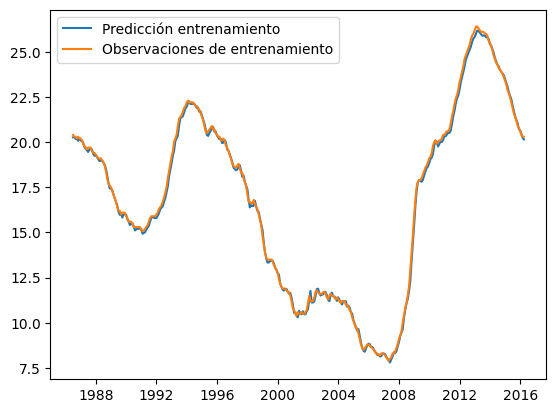

In [44]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Predicción entrenamiento', 'Observaciones de entrenamiento'])

2/2 [==============================] - 0s 4ms/step


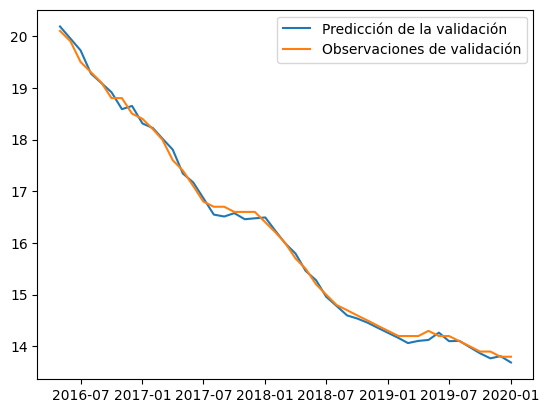

In [45]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Predicción de la validación', 'Observaciones de validación'])

2/2 [==============================] - 0s 5ms/step


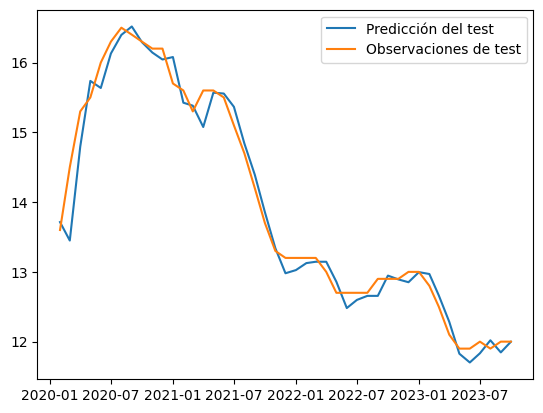

In [46]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Predicción del test', 'Observaciones de test'])

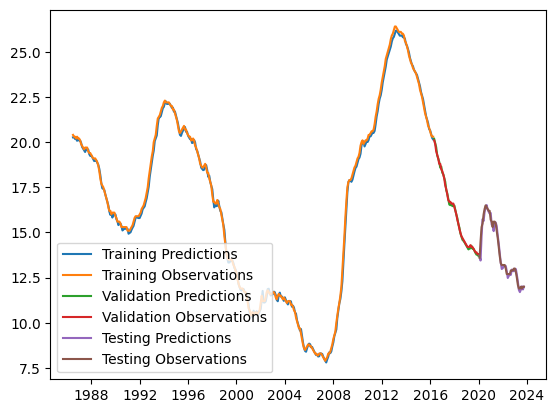

In [47]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Epoch 1/100
12/12 [==============================] - 0s 8ms/step - loss: 0.0203 - mean_absolute_error: 0.1130 - val_loss: 0.0114 - val_mean_absolute_error: 0.0859
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0208 - mean_absolute_error: 0.1130 - val_loss: 0.0110 - val_mean_absolute_error: 0.0840
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_absolute_error: 0.1146 - val_loss: 0.0255 - val_mean_absolute_error: 0.1330
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0301 - mean_absolute_error: 0.1353 - val_loss: 0.0117 - val_mean_absolute_error: 0.0895
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0230 - mean_absolute_error: 0.1190 - val_loss: 0.0162 - val_mean_absolute_error: 0.1070
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0423 - mean_absolute_error: 0.1639 - val_loss: 0.0443 - val_mean_absolute_error: 0.1860
Epoch 7/100
12/12 [===

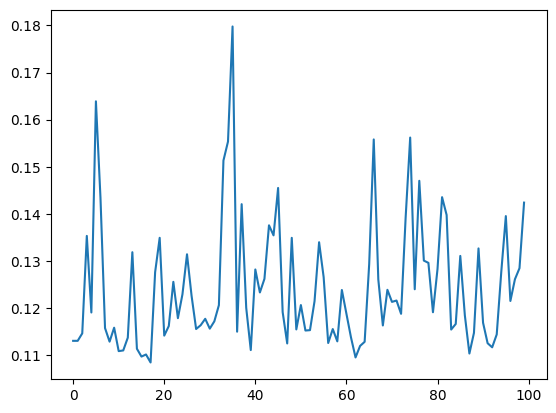

In [53]:
# Entrenar el modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)



# plot metrics
plt.plot(history.history['mean_absolute_error'])
plt.show()

In [51]:
min(train_loss)
min(train_mae)

0.11600831896066666